# processing dataframe

In [18]:
import pandas as pd
import numpy as np 

df_12 = pd.read_csv("./p12_editing_summary.csv")
df_4 = pd.read_csv("./p04_clinvar_summary.csv")

In [19]:
df_12 = df_12[df_12.spacer_length == 20]
df_4 = df_4[df_4.spacer_length == 20]

In [20]:
df_4['spacer_add_g'] = df_4['spacer_add_g'].apply(lambda x: x[1:].upper())

In [21]:
spacer_target_dict = df_4.set_index('spacer_add_g')['target_seq_adj'].to_dict()


In [22]:
spacer_target_dict

{'CAGATGGGGCTCCTGGATCA': 'ACTGTGTCGGAAGGTCAAGTTCCAGGTGGACTTCAACCTGATCaGATGGGGCTCCTGGATCATCTACCCCAAGCAGTACAACGCCTATC',
 'CATCCTCGTCGAGGGCATTC': 'CCTGGAGCTCCTCAAGGAGGCCACCCGAAAGGAGCTGAATGCCCtCGACGAGGATGGCATGACCCCCACTCTCTGGGCTGCCTACCATG',
 'ACAGCCACGGCTGCGCTGCG': 'GCTACGCCTGTCCCCCAGCCCTACCTCGCAGCGCAGCCGTGGCtGTGCTTCCTCTCACTCATCCCAGACACAGGGTGGGGGCAGCGTCA',
 'GCAGGCCACGCGCCTGGAAG': 'CTACAACTCCACACTGACCTGGCAGCAGTATGGTGCGCTGTGCaGGCCACGCGCCTGGAAGGAGACCAACATGGCGCGCACCCAGATCC',
 'ATGGTCCTGGATTTGGACTG': 'ATACTTCGGGGGACAGCTGGTAAGCAGTCCAAATCCAGGACCAtGAGATAGCTGTACTTTCAAGTTTTCCAAGGCGCAGACACCCATCG',
 'TTTGTTCACTCTGCTGAAGT': 'TATTAAAGTTGGTTCTACTGCTGTCCAAGTAACTTCAGCAGAGtGAACAAAAGTCCTAGGGCAATCAGTCTTTCTAAATGACATTTATT',
 'CAGTTCAGTCACTTCGAGCA': 'GATAACTGGTTGGTCCAATGGGAAGGTTGATGCTCGAAGTGACtGAACTGGGGAGGTCATCTTTAAGGACAATTTTTCTTCTGCAATTG',
 'CTCCGAGTCCTCCAGGTGCT': 'CAAAGGAAAAGACATCAACACGATTAAATCCCTCCGAGTCCTCCaGGTGCTACGACCTCTTAAAACCATCAAGCGGCTGCCAAAGCTCA',
 'CATATTCATCAGCTAGCCTG': 'GATACAGTACAGCCTGAATGTGGCAGACAG

In [23]:
def replace_spacer_with_target(row, spacer_target_dict):
    spacer = row['spacer']
    if spacer in spacer_target_dict.keys():
        row['target'] = spacer_target_dict[spacer]
    return row

df_12 = df_12.apply(replace_spacer_with_target, axis=1, spacer_target_dict=spacer_target_dict)


In [24]:
df_12['target'] = df_12['target'].apply(lambda x: x.upper())

In [25]:
def reverse(seq):
    dic = {'A':'T', 'T':'A', 'C':'G', 'G':'C'}
    reverse = seq[::-1]
    new = ""
    for x in reverse:
        new += dic[x]
    return new 

In [26]:
for index, row in df_12.iterrows():
    if row['spacer'] not in row['target']:
        df_12.at[index, 'target'] = reverse(row['target'])

In [27]:
for x in df_12.iterrows():
    if x[1]['spacer'] in x[1]['target']:
        continue
    else:
        print('noooooooooo :(')

In [28]:
def set_50(spacer, target):
    idx = target.index(spacer)
    if idx <= 8:
        final = target[:idx+20+21]
        final += (50 - len(final)) * 'N'
        return final 
        
    else:
        return target[idx-9:idx+20+21]
    

In [29]:
df_12['target'] = df_12.apply(lambda row: set_50(row['spacer'], row['target']), axis=1)


In [32]:
import pandas as pd
import numpy as np
from Bio.SeqUtils import MeltingTemp as mt

# Model

from __future__ import absolute_import, division
from __future__ import print_function
import sys, string, pickle, subprocess, os, datetime, gzip, time
from collections import defaultdict, OrderedDict
import glob
import numpy as np, pandas as pd
from scipy.special import expit


'''
  Featurization
'''
ohe_encoder = {
  'A': [1, 0, 0, 0],
  'C': [0, 1, 0, 0],
  'G': [0, 0, 1, 0],
  'T': [0, 0, 0, 1],
}
def __one_hot_encode(seq):
  ohe = []
  for nt in seq:
    ohe += ohe_encoder[nt]
  return ohe
  
def __get_one_hot_encoder_nms(start_pos, end_pos):
  nms = []
  nts = list('ACGT')
  for pos in range(start_pos, end_pos + 1):
    for nt in nts:
      nms.append('%s%s' % (nt, pos))
  return nms

dint_encoder = {
  'AA': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'AC': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'AG': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'AT': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'CA': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'CC': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'CG': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'CT': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
  'GA': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
  'GC': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
  'GG': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
  'GT': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  'TA': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
  'TC': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
  'TG': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
  'TT': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
}
def __dinucleotide_encode(seq):
  ohe = []
  for idx in range(len(seq) - 1):
    ohe += dint_encoder[seq[idx : idx + 2]]
  return ohe

def __get_dinucleotide_nms(start_pos, end_pos):
  nms = []
  dints = sorted(list(dint_encoder.keys()))
  for pos in range(start_pos, end_pos):
    for dint in dints:
      nms.append('%s%s' % (dint, pos))
  return nms


def featurize(df):
    '''
    This function expects a DataFrame with at least one column named 'sequence'
    that contains the DNA sequences to be featurized.
    '''
    # Initialize a list to collect feature arrays
    feature_records = []

    # Iterate over each sequence in the DataFrame
    for _, row in df.iterrows():
        seq = row['target']
        
        pos_to_idx = lambda pos: pos + 19
        seq = seq[pos_to_idx(-9) : pos_to_idx(21) + 1]
        
        features = []
        features.append(row['eff'])
        one_hot_features = __one_hot_encode(seq)
        features += one_hot_features

        dinucleotide_features = __dinucleotide_encode(seq)
        features += dinucleotide_features

        nuc_counts = [
            seq.count('A'),
            seq.count('C'),
            seq.count('G'),
            seq.count('T'),
            seq.count('G') + seq.count('C'),
        ]
        features += nuc_counts

        mt_features = [
            mt.Tm_NN(seq),
            mt.Tm_NN(seq[-5:]),
            mt.Tm_NN(seq[-13:-5]),
            mt.Tm_NN(seq[-21:-13]),
        ]
        features += mt_features

        feature_records.append(features)

    # Define the column names with more descriptive names
    one_hot_columns = __get_one_hot_encoder_nms(-9, 21)
    dinucleotide_columns = __get_dinucleotide_nms(-9, 21)
    nuc_count_columns = ['count_A', 'count_C', 'count_G', 'count_T', 'count_GC']
    mt_columns = ['Tm_NN_full', 'Tm_NN_last5', 'Tm_NN_13to5', 'Tm_NN_21to13']

    column_names = ["eff"] + one_hot_columns + dinucleotide_columns + nuc_count_columns + mt_columns

    # Convert the list of feature arrays to a DataFrame with column names
    return pd.DataFrame(feature_records, columns=column_names)


In [54]:
df_12

,spacer,target,strand,spacer_length,pos,context,eff
0,CAGATGGGGCTCCTGGATCA,CAACCTGATCAGATGGGGCTCCTGGATCATCTACCCCAAGCAGTAC...,1.0,20.0,-22.0,CTGATCA,0.000033
1,CAGATGGGGCTCCTGGATCA,CAACCTGATCAGATGGGGCTCCTGGATCATCTACCCCAAGCAGTAC...,1.0,20.0,-19.0,ATCAGAT,0.002250
2,CAGATGGGGCTCCTGGATCA,CAACCTGATCAGATGGGGCTCCTGGATCATCTACCCCAAGCAGTAC...,1.0,20.0,-17.0,CAGATGG,0.002133
3,CAGATGGGGCTCCTGGATCA,CAACCTGATCAGATGGGGCTCCTGGATCATCTACCCCAAGCAGTAC...,1.0,20.0,-4.0,TGGATCA,0.000033
4,CATCCTCGTCGAGGGCATTC,GGGTCATGCCATCCTCGTCGAGGGCATTCAGCTCCTTTCGGGTGGC...,0.0,20.0,-24.0,GTCATGC,0.000467
...,...,...,...,...,...,...,...
7428,CGGTCACTTCAAGCATCAAC,TCCCCAGTTCGGTCACTTCAAGCATCAACCTTCCCATTGGACCAAC...,0.0,20.0,-15.0,GTCACTT,0.395900
7429,CGGTCACTTCAAGCATCAAC,TCCCCAGTTCGGTCACTTCAAGCATCAACCTTCCCATTGGACCAAC...,0.0,20.0,-10.0,TTCAAGC,0.191800
7430,CGGTCACTTCAAGCATCAAC,TCCCCAGTTCGGTCACTTCAAGCATCAACCTTCCCATTGGACCAAC...,0.0,20.0,-9.0,TCAAGCA,0.102000
7431,CGGTCACTTCAAGCATCAAC,TCCCCAGTTCGGTCACTTCAAGCATCAACCTTCCCATTGGACCAAC...,0.0,20.0,-6.0,AGCATCA,0.061200


In [33]:
df_process = featurize(df_12)

In [47]:
np.unique(df_12.spacer_length)

array([20.])

In [35]:
df_process.head()

,eff,A-9,C-9,G-9,T-9,A-8,C-8,G-8,T-8,A-7,...,TT20,count_A,count_C,count_G,count_T,count_GC,Tm_NN_full,Tm_NN_last5,Tm_NN_13to5,Tm_NN_21to13
0,0.000033,1,0,0,0,0,0,1,0,1,...,0,7,10,8,6,18,65.381098,-25.473296,3.111280,8.482439
1,0.002250,1,0,0,0,0,0,1,0,1,...,0,7,10,8,6,18,65.381098,-25.473296,3.111280,8.482439
2,0.002133,1,0,0,0,0,0,1,0,1,...,0,7,10,8,6,18,65.381098,-25.473296,3.111280,8.482439
3,0.000033,1,0,0,0,0,0,1,0,1,...,0,7,10,8,6,18,65.381098,-25.473296,3.111280,8.482439
4,0.000467,1,0,0,0,0,0,0,1,0,...,0,4,10,8,9,18,66.213713,-26.148099,11.793416,9.379100


In [49]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr


X = df_process[[x for x in df_process.columns if x != 'eff']]  
y = df_process['eff']               
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the gradient boosting regressor model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, max_depth=40, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

# Print the evaluations
print(f"MSE: {mse:.2f}")
print(f"R-squared: {r2:.2f}")
print(f"Pearson's Correlation: {pearson_corr:.2f}")
print(f"Spearman's Correlation: {spearman_corr:.2f}")

MSE: 0.04
R-squared: 0.10
Pearson's Correlation: 0.36
Spearman's Correlation: 0.39


In [44]:
import numpy as np
from sklearn.model_selection import cross_val_score

# Assuming your DataFrame 'df_process' is already loaded and preprocessed
X = df_process[[x for x in df_process.columns if x != 'eff']]
y = df_process['eff']

# Create the gradient boosting regressor model
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, max_depth=4, random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

# Print the R-squared scores and average score
print("R-squared scores for each fold:", cv_scores)
print("Average R-squared across all folds:", np.mean(cv_scores))


R-squared scores for each fold: [-0.06593667  0.11282542  0.07753418  0.03963386  0.02174959]
Average R-squared across all folds: 0.037161273762085265


# My model

In [58]:
import numpy as np 
import pandas as pd 
from Bio.SeqUtils import MeltingTemp as mt
from Bio.Seq import Seq
def generate_feature_mx(df_ed):
    feature_records = []
    df_ed['spacer_length'] = np.round(df_ed['spacer_length']).astype(int)
    df_ed['pos'] = np.round(df_ed['pos']).astype(int)
    nucleotides = ['A', 'C', 'G', 'T']
    df_ed['target_no_pam'] = df_ed['target'].apply(lambda x: x[:-10])
    df_ed['pam'] = df_ed['target'].apply(lambda x: x[-10:])
    

    for _, row in df_ed.iterrows():
        features = {
            'eff': row['eff'],
            'SGN_Strand': row['strand'],
            'Editing_Position': -1 * row['pos']
        }

        unique_editing_positions = set(df_ed['pos'].tolist())
        positions = [0 for x in unique_editing_positions]
        editing_position = row['pos']

        # for index, position in enumerate(unique_editing_positions):
        #     if position != editing_position:
        #         features[f'Editing_P{position}'] = positions[index]
        #     else:
        #         positions[index] = 1
        #         features[f'Editing_P{position}'] = positions[index]

        # processing context sequence
        seq_nb = row['context']
        for k, v in enumerate(seq_nb):
            if k == 3:
                continue
            for nt in nucleotides:
                features[f'Context_P{str(k - 3)}_{nt}'] = int(nt == v)

        features['Editing_mt'] = mt.Tm_Wallace(seq_nb) / 100
        sgn = row['target']
        for k in range(0, 30, 4):
            seq_nb2 = Seq(sgn[k:k+10])
            mt_w = mt.Tm_Wallace(seq_nb)
            features['SGN_mt_w_'+str(k)] = mt_w/100

        # Processing target sequence
        for k, nt in enumerate(sgn, -len(sgn)):
            pos_label = k + 11 if k + 10 >= 0 else k + 10
            for bs in nucleotides:
                features[f'SGN_P{pos_label}_{bs}'] = int(bs == nt)


        # # dincucleotide
        # context_ohe = encode_7mer_excluding_middle(seq_nb)
        # context_nm = get_dinucleotide_nms_context()
        # for ohe in zip(context_nm,context_ohe):
        #     features["di_context_"+ohe[0]] = ohe[1]
        
        # # target
        target_no_pam = row['target_no_pam']
        # dseq = __dinucleotide_encode(target_no_pam)
        # dnms = __get_dinucleotide_nms(-31,-1)
        # for ohe in zip(dnms,dseq):
        #     features["di_target_no_pam_"+ohe[0]] = ohe[1]

        # # pam 
        # pam = row['pam']
        # pamseq = __dinucleotide_encode(pam)
        # pamnms = __get_dinucleotide_nms(1,10)
        # for ohe in zip(pamnms,pamseq):
        #     features["di_pam_"+ohe[0]] = ohe[1]

        # nucleotide counts
        counts = len(target_no_pam)
        nuc_content = [
            target_no_pam.count('A')/counts,
            target_no_pam.count('C')/counts,
            target_no_pam.count('G')/counts,
            target_no_pam.count('T')/counts,
            (target_no_pam.count('G') + target_no_pam.count('C'))/counts
          ]
        nuc_names = ['A', 'C', 'G', 'T', 'GC']

        for nc in zip(nuc_names, nuc_content):
            features[nc[0]+'content'] = nc[1]

        feature_records.append(features)

    df_stat_feat = pd.DataFrame(feature_records)
    return df_stat_feat

In [59]:
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import shap
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression




def rf_training_vis(df_stat_feat, L):
    df_ml_stat = pd.DataFrame()
    smpl = str(L) + 'bp'
    output_folder = f"{smpl}_data"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    X = df_stat_feat.drop(columns=['eff'])
    y = df_stat_feat.eff.to_list()
    kf = KFold(n_splits=5, shuffle=True, random_state = 42)
    lst_y_eff = []
    lst_y_pre = []
    print("Starting training")
    for k, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"Training number: {k+1} of {sum(1 for _ in kf.split(X))}")
        X_train = X.loc[train_index, :]
        X_test = X.loc[test_index, :]
        y_train = [y[i] for i in train_index]
        y_test = [y[i] for i in test_index]
        regr = RandomForestRegressor(n_estimators=200, max_depth=40, random_state=None)
        regr.fit(X_train, y_train)
        ##
        y_rf = list(regr.predict(X_test))
        lst_y_eff = lst_y_eff + y_test
        lst_y_pre = lst_y_pre + y_rf
        ##
        idx = len(df_ml_stat)
        df_ml_stat.loc[idx, 'Editor'] = smpl
        df_ml_stat.loc[idx, 'stat'] = 'r-squared'
        df_ml_stat.loc[idx, 'score'] = regr.score(X_test, y_test)
    
        ####
        idx = len(df_ml_stat)
        df_ml_stat.loc[idx, 'Editor'] = smpl
        df_ml_stat.loc[idx, 'stat'] = 'pearsonr'
        df_ml_stat.loc[idx, 'score'] = stats.pearsonr(y_rf, y_test)[0]
    
        ####
        idx = len(df_ml_stat)
        df_ml_stat.loc[idx, 'Editor'] = smpl
        df_ml_stat.loc[idx, 'stat'] = 'spearmanr'
        df_ml_stat.loc[idx, 'score'] = stats.spearmanr(y_rf, y_test)[0]

        ####
        idx = len(df_ml_stat)
        mse = mean_squared_error(y_test, y_rf)
        df_ml_stat.loc[idx, 'Editor'] = smpl
        df_ml_stat.loc[idx, 'stat'] = 'mse'
        df_ml_stat.loc[idx, 'score'] = mse
    
        ##
    feat_name = X_test.columns
    result = permutation_importance(
        regr, X, y, n_repeats=10, random_state=42, n_jobs=2
    )
    print("calculating feature importance...")

    forest_importances = pd.Series(result.importances_mean, index=feat_name)
    #
    dct_feat = dict(zip(feat_name, forest_importances))
    dct_feat = dict(sorted(dct_feat.items(), key=lambda item: item[1], reverse=True))
    print("Features by importance with full model:")
    print(dct_feat)
    
    #
    # plt.figure(figsize = (8, 10))
    # sns.barplot(y = list(dct_feat.keys()), x = list(dct_feat.values()), width=0.6)
    # plt.ylim([10.5, -0.5])
    # plt.yticks(fontsize=18)
    # plt.title(smpl, fontsize=18)
    # plt.savefig(os.path.join(output_folder, f"{smpl}_rf_xgb_importances.png"), bbox_inches='tight')
    # plt.close()
    
    ##
    explainer = shap.TreeExplainer(regr)
    plt.figure(figsize = (12, 10))
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, max_display=10, show=False)
    plt.show()
    # plt.savefig(os.path.join(output_folder, f"{smpl}_rf_xgb_shap_values.png"), bbox_inches='tight')
    plt.close()
    
    ##
    # plt.figure(figsize=(6,6))
    # plt.plot([0, 1], [0, 1], c='k', linestyle='dashed', lw=0.75)
    # sns.scatterplot(x = lst_y_eff, y = lst_y_pre)
    # plt.xlim([0, 1])
    # plt.ylim([0, 1])
    # plt.xlabel('ABE editing')
    # plt.ylabel('ABE prediction')
    # plt.savefig(os.path.join(output_folder, f"{smpl}_rf_xgb_scatterplot.png"), bbox_inches='tight')
    # plt.close()
    
    print(smpl)
    print(df_ml_stat)
    average_scores = df_ml_stat.groupby('stat')['score'].mean()
    # Print the average scores
    print("average_stats:")
    print(average_scores)
    print(f"ended random forest processing for spacer length = {L}")


Starting training
Training number: 1 of 5
Training number: 2 of 5
Training number: 3 of 5
Training number: 4 of 5
Training number: 5 of 5
calculating feature importance...
Features by importance with full model:
{'Editing_Position': 1.0463561150410203, 'SGN_Strand': 0.33768450022142643, 'Tcontent': 0.16093205933031074, 'Gcontent': 0.11010030550111816, 'SGN_P-9_T': 0.04465379447819432, 'GCcontent': 0.013859059691335385, 'Acontent': 0.012377138098864838, 'SGN_P-14_A': 0.009367834586817048, 'Context_P1_C': 0.008078777562815987, 'SGN_P-16_C': 0.0073466855732465365, 'SGN_P-27_G': 0.006942288714448308, 'SGN_P-9_C': 0.006750046185605818, 'SGN_P-26_A': 0.005556540341762328, 'SGN_P-11_C': 0.005520695255419872, 'Ccontent': 0.005294293054049148, 'SGN_P-10_T': 0.005101232813007883, 'SGN_P-18_A': 0.004525063954190523, 'SGN_P-34_T': 0.004504910656993877, 'SGN_P-23_A': 0.004238899211428793, 'SGN_P-30_A': 0.0038058159304417806, 'SGN_P-32_G': 0.00366175192411885, 'SGN_P-30_G': 0.0034347895937310137, 'C

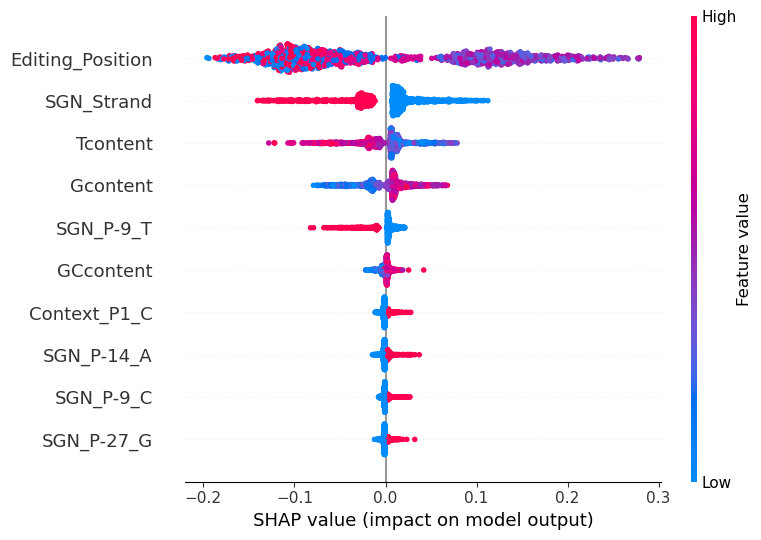

20bp
   Editor       stat     score
0    20bp  r-squared  0.653554
1    20bp   pearsonr  0.811431
2    20bp  spearmanr  0.814748
3    20bp        mse  0.014418
4    20bp  r-squared  0.758744
5    20bp   pearsonr  0.889734
6    20bp  spearmanr  0.840214
7    20bp        mse  0.010192
8    20bp  r-squared  0.627811
9    20bp   pearsonr  0.793175
10   20bp  spearmanr  0.850655
11   20bp        mse  0.015168
12   20bp  r-squared  0.728771
13   20bp   pearsonr  0.857127
14   20bp  spearmanr  0.822248
15   20bp        mse  0.009263
16   20bp  r-squared  0.677184
17   20bp   pearsonr  0.826733
18   20bp  spearmanr  0.850143
19   20bp        mse  0.013023
average_stats:
stat
mse          0.012413
pearsonr     0.835640
r-squared    0.689213
spearmanr    0.835601
Name: score, dtype: float64
ended random forest processing for spacer length = 20


In [60]:
rf_training_vis(generate_feature_mx(df_12), 20)

Starting training
Training number: 1 of 5
Training number: 2 of 5
Training number: 3 of 5
Training number: 4 of 5
Training number: 5 of 5
calculating feature importance...
Features by importance with full model:
{'T12': 0.030071360169615802, 'count_T': 0.025817178408642914, 'CA-3': 0.012429702921315955, 'AG-4': 0.0111444745689827, 'A0': 0.010994879503703614, 'CG4': 0.007332041607647355, 'TG-7': 0.0072855996976470385, 'A-2': 0.00627535622147084, 'GT-8': 0.004063205412592275, 'CC5': 0.003685088870187825, 'AG7': 0.003566120205018486, 'AA-1': 0.0026175766183214265, 'AG11': 0.0026020141790307205, 'T0': 0.002276214431409329, 'AT3': 0.00195063666379256, 'GA1': 0.001877479855201436, 'Tm_NN_13to5': 0.0017937102498988499, 'Tm_NN_last5': 0.001687980752156082, 'GG2': 0.001382379270369083, 'TA-3': 0.0013751739003810104, 'AA-6': 0.0011931719350561586, 'GT5': 0.0011522785109669199, 'TT-8': 0.0010767951656645125, 'CA-1': 0.0010370724331575931, 'TG9': 0.001021853262137684, 'Tm_NN_full': 0.0008279132175

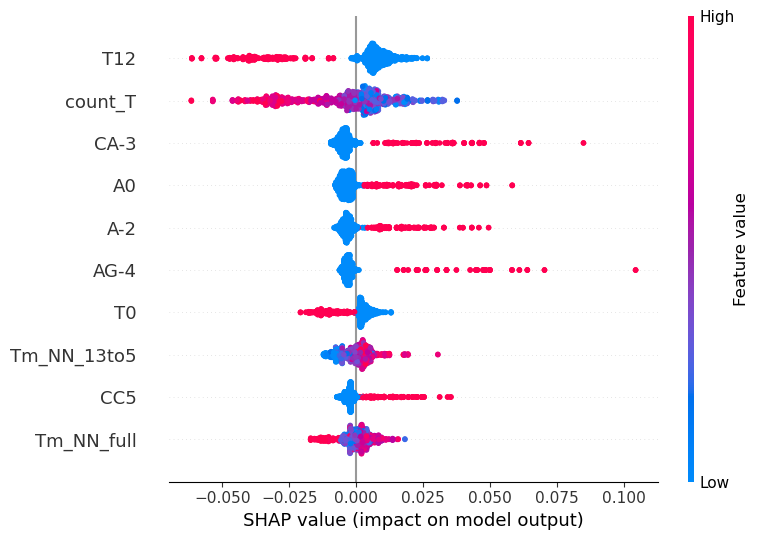

20bp
   Editor       stat     score
0    20bp  r-squared  0.064630
1    20bp   pearsonr  0.385340
2    20bp  spearmanr  0.405322
3    20bp        mse  0.038926
4    20bp  r-squared  0.014046
5    20bp   pearsonr  0.332657
6    20bp  spearmanr  0.368094
7    20bp        mse  0.041653
8    20bp  r-squared -0.152020
9    20bp   pearsonr  0.253622
10   20bp  spearmanr  0.339063
11   20bp        mse  0.046950
12   20bp  r-squared  0.167077
13   20bp   pearsonr  0.444495
14   20bp  spearmanr  0.436075
15   20bp        mse  0.028445
16   20bp  r-squared  0.049233
17   20bp   pearsonr  0.335080
18   20bp  spearmanr  0.373736
19   20bp        mse  0.038357
average_stats:
stat
mse          0.038866
pearsonr     0.350239
r-squared    0.028593
spearmanr    0.384458
Name: score, dtype: float64
ended random forest processing for spacer length = 20


In [61]:
rf_training_vis(df_process, 20)

In [76]:
idx = df_12.groupby('spacer')['eff'].idxmax()
result_df = df_12.loc[idx]



351

In [77]:
df_process2 = featurize(result_df)

In [68]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy import stats
import shap
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import os

def gb_training_vis(df_stat_feat, L):
    df_ml_stat = pd.DataFrame()
    smpl = str(L) + 'bp'
    output_folder = f"{smpl}_data"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    X = df_stat_feat.drop(columns=['eff'])
    y = df_stat_feat['eff'].tolist()
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    lst_y_eff = []
    lst_y_pre = []
    print("Starting training")
    for k, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"Training number: {k+1} of {sum(1 for _ in kf.split(X))}")
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = [y[i] for i in train_index]
        y_test = [y[i] for i in test_index]
        regr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=8, random_state=None)
        regr.fit(X_train, y_train)

        y_gb = list(regr.predict(X_test))
        lst_y_eff += y_test
        lst_y_pre += y_gb

        idx = len(df_ml_stat)
        df_ml_stat.loc[idx, 'Editor'] = smpl
        df_ml_stat.loc[idx, 'stat'] = 'r-squared'
        df_ml_stat.loc[idx, 'score'] = regr.score(X_test, y_test)

        idx = len(df_ml_stat)
        df_ml_stat.loc[idx, 'Editor'] = smpl
        df_ml_stat.loc[idx, 'stat'] = 'pearsonr'
        df_ml_stat.loc[idx, 'score'] = stats.pearsonr(y_gb, y_test)[0]

        idx = len(df_ml_stat)
        df_ml_stat.loc[idx, 'Editor'] = smpl
        df_ml_stat.loc[idx, 'stat'] = 'spearmanr'
        df_ml_stat.loc[idx, 'score'] = stats.spearmanr(y_gb, y_test)[0]

        idx = len(df_ml_stat)
        mse = mean_squared_error(y_test, y_gb)
        df_ml_stat.loc[idx, 'Editor'] = smpl
        df_ml_stat.loc[idx, 'stat'] = 'mse'
        df_ml_stat.loc[idx, 'score'] = mse

    feat_name = X_test.columns
    result = permutation_importance(
        regr, X, y, n_repeats=10, random_state=42, n_jobs=2
    )
    print("Calculating feature importance...")

    forest_importances = pd.Series(result.importances_mean, index=feat_name)
    dct_feat = {feat: importance for feat, importance in sorted(forest_importances.items(), key=lambda item: item[1], reverse=True)}
    print("Features by importance with full model:")
    print(dct_feat)

    explainer = shap.Explainer(regr)
    shap_values = explainer(X)
    shap.summary_plot(shap_values.values, X, feature_names=X.columns, max_display=10, show=False)
    plt.show()
    plt.close()

    print(smpl)
    print(df_ml_stat)
    average_scores = df_ml_stat.groupby('stat')['score'].mean()
    print("Average stats:")
    print(average_scores)
    print(f"Ended gradient boosting processing for spacer length = {L}")



Starting training
Training number: 1 of 5
Training number: 2 of 5
Training number: 3 of 5
Training number: 4 of 5
Training number: 5 of 5
Calculating feature importance...
Features by importance with full model:
{'T12': 0.25671210964056035, 'count_T': 0.06822149398528261, 'AG-4': 0.06516278378378114, 'A-2': 0.049496845594168726, 'A0': 0.0461366101115392, 'GA1': 0.03445562492251773, 'count_G': 0.03373765961654903, 'AG7': 0.03292506240378529, 'Tm_NN_full': 0.03174851548369005, 'AG1': 0.02471400202082056, 'GG20': 0.01612297722709527, 'A7': 0.014696251816921847, 'count_A': 0.014491563037055366, 'GT12': 0.0115985696353741, 'CA-5': 0.011149698547871423, 'T-9': 0.0107370657560811, 'T2': 0.010439797895065984, 'TG8': 0.008821754089707767, 'TG9': 0.007740316390479019, 'TT20': 0.007307655481450692, 'CA15': 0.006822809272315466, 'T0': 0.006494887647464742, 'AC1': 0.0063478406270088715, 'AC-5': 0.006224258459581522, 'CA4': 0.005250263862133819, 'CT-9': 0.005246095260045802, 'C16': 0.005215673894668

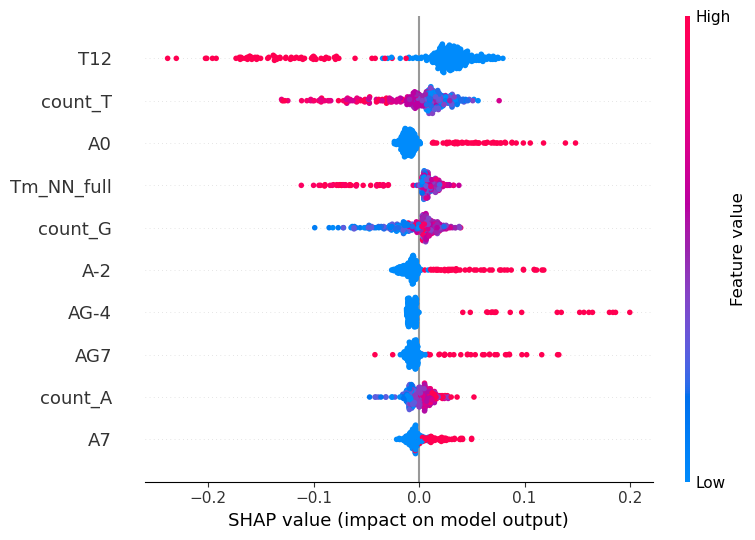

20bp
   Editor       stat     score
0    20bp  r-squared  0.221338
1    20bp   pearsonr  0.479581
2    20bp  spearmanr  0.539973
3    20bp        mse  0.068087
4    20bp  r-squared  0.305283
5    20bp   pearsonr  0.575609
6    20bp  spearmanr  0.579949
7    20bp        mse  0.035813
8    20bp  r-squared  0.224015
9    20bp   pearsonr  0.501552
10   20bp  spearmanr  0.574455
11   20bp        mse  0.048857
12   20bp  r-squared  0.394089
13   20bp   pearsonr  0.634488
14   20bp  spearmanr  0.627790
15   20bp        mse  0.043750
16   20bp  r-squared  0.346572
17   20bp   pearsonr  0.591936
18   20bp  spearmanr  0.566652
19   20bp        mse  0.041185
Average stats:
stat
mse          0.047538
pearsonr     0.556633
r-squared    0.298259
spearmanr    0.577764
Name: score, dtype: float64
Ended gradient boosting processing for spacer length = 20


In [78]:
gb_training_vis(df_process2, 20)

Starting training
Training number: 1 of 5
Training number: 2 of 5
Training number: 3 of 5
Training number: 4 of 5
Training number: 5 of 5
Calculating feature importance...
Features by importance with full model:
{'Editing_Position': 1.2073464122666, 'SGN_Strand': 0.5212719294090252, 'Gcontent': 0.43972427571730643, 'Tcontent': 0.33064504041589854, 'SGN_P-9_T': 0.15901603901717642, 'Acontent': 0.11007768465717058, 'SGN_P-9_C': 0.0836960651859232, 'SGN_P-24_T': 0.06920776447189467, 'SGN_P-5_T': 0.056484137520929914, 'SGN_P-3_T': 0.05340339795016308, 'SGN_P-34_T': 0.05272264811796108, 'SGN_P-14_A': 0.04377657585053396, 'SGN_P-5_A': 0.03991134162686313, 'SGN_P-4_A': 0.037200573763238765, 'SGN_P-26_A': 0.034424212517057164, 'Context_P1_C': 0.0333342385729953, 'SGN_P7_G': 0.03150697968081604, 'SGN_P-18_A': 0.027202673588285008, 'SGN_P-23_A': 0.024838108813933633, 'SGN_P-32_C': 0.022369762642863732, 'SGN_P-23_G': 0.020569800767837675, 'Context_P-1_G': 0.020453510812557075, 'SGN_P-33_C': 0.020

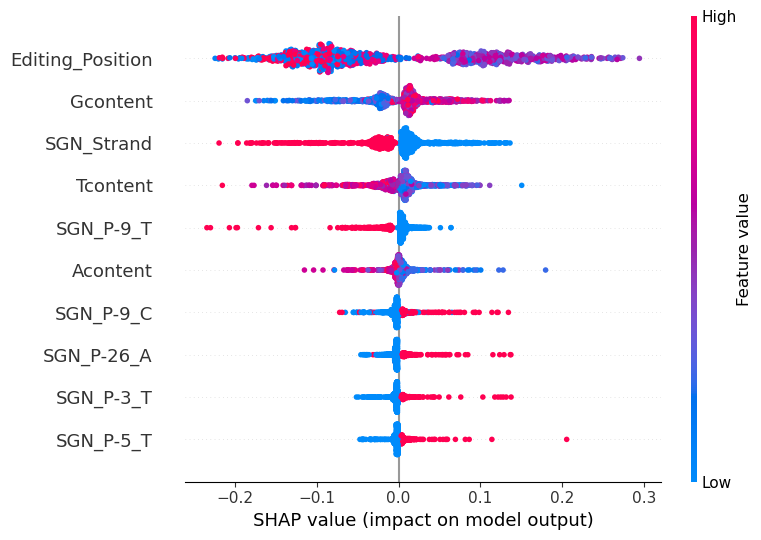

20bp
   Editor       stat     score
0    20bp  r-squared  0.313288
1    20bp   pearsonr  0.689482
2    20bp  spearmanr  0.754187
3    20bp        mse  0.028578
4    20bp  r-squared  0.583564
5    20bp   pearsonr  0.770465
6    20bp  spearmanr  0.756185
7    20bp        mse  0.017593
8    20bp  r-squared  0.260055
9    20bp   pearsonr  0.678966
10   20bp  spearmanr  0.772238
11   20bp        mse  0.030156
12   20bp  r-squared  0.465780
13   20bp   pearsonr  0.735906
14   20bp  spearmanr  0.724001
15   20bp        mse  0.018244
16   20bp  r-squared  0.489529
17   20bp   pearsonr  0.729854
18   20bp  spearmanr  0.742954
19   20bp        mse  0.020594
Average stats:
stat
mse          0.023033
pearsonr     0.720935
r-squared    0.422443
spearmanr    0.749913
Name: score, dtype: float64
Ended gradient boosting processing for spacer length = 20


In [67]:
gb_training_vis(generate_feature_mx(df_12), 20)